In [1]:
# nearest_neighbor.py
import pandas as pd

file_path = "Dataset.xlsx"

# Load data (same as your MILP + Holmes & Parker)
Index_Details = pd.read_excel(file_path, sheet_name="City")
Chennai = pd.read_excel(file_path, sheet_name="Chennai")
Visit_Duration = pd.read_excel(file_path, sheet_name="Visit Duration")

A = Index_Details["Index"].dropna().astype(int).tolist()   # nodes (0 = hub)
T = Index_Details["Time"].dropna().astype(int).tolist()    # days
Q = 10  # daily time budget (hours)

t_time = Chennai.set_index(['from_index', 'to_index'])['Travel Time (hours)'].to_dict()
for i in A:
    t_time[(i, i)] = 1e6  # large self-loop

tv = Visit_Duration.set_index(['Index'])['time'].to_dict()

CUSTOMERS = [a for a in A if a != 0]
DAYS = sorted(T)

def route_time(route):
    total = 0.0
    for i, j in zip(route[:-1], route[1:]):
        total += t_time[(i, j)]
        if j != 0:
            total += tv.get(j, 0.0)
    return total

def route_obj(route):
    val = 0.0
    for i, j in zip(route[:-1], route[1:]):
        tij = t_time[(i, j)]
        if tij < 1e5:
            val += 1.0 / tij
    return val

def nearest_neighbor_construct():
    """Greedy nearest neighbor route construction per day."""
    unassigned = set(CUSTOMERS)
    routes = {d: [0, 0] for d in DAYS}

    for d in DAYS:
        if not unassigned:
            break

        route = [0]
        current = 0
        total_time = 0.0

        while True:
            # find nearest feasible neighbor
            best_next = None
            best_dist = float("inf")

            for j in unassigned:
                travel = t_time[(current, j)]
                stay = tv.get(j, 0.0)
                # time if we visit j and return to hub
                projected_time = total_time + travel + stay + t_time[(j, 0)]
                if projected_time <= Q and travel < best_dist:
                    best_dist = travel
                    best_next = j

            if best_next is None:
                break  # no more feasible customers

            # go to best_next
            route.append(best_next)
            total_time += t_time[(current, best_next)] + tv.get(best_next, 0.0)
            current = best_next
            unassigned.remove(best_next)

        # return to hub
        route.append(0)
        routes[d] = route

    return routes, unassigned

def print_routes(routes, Q):
    print("\n=== Nearest Neighbor Heuristic Result ===")
    total_obj = 0.0
    for d in sorted(routes.keys()):
        r = routes[d]
        if len(r) <= 2:
            continue
        obj = route_obj(r)
        t = route_time(r)
        total_obj += obj
        print(f"\nDay {d}:")
        print(" Route:", " -> ".join(map(str, r)))
        print(f" Time: {t:.2f} / {Q}")
        print(f" Cost (sum 1/t_ij): {obj:.6f}")
        print(" Arcs:")
        for a, b in zip(r[:-1], r[1:]):
            print(f"  {a} -> {b}  (t_ij={t_time[(a,b)]:.3f})")
    print(f"\nTotal objective (all days): {total_obj:.6f}")

if __name__ == "__main__":
    routes, unassigned = nearest_neighbor_construct()
    print_routes(routes, Q)
    if unassigned:
        print("\nUnassigned customers:", sorted(unassigned))



=== Nearest Neighbor Heuristic Result ===

Day 1:
 Route: 0 -> 6 -> 8 -> 4 -> 7 -> 0
 Time: 7.46 / 10
 Cost (sum 1/t_ij): 57.820188
 Arcs:
  0 -> 6  (t_ij=0.077)
  6 -> 8  (t_ij=0.109)
  8 -> 4  (t_ij=0.099)
  4 -> 7  (t_ij=0.058)
  7 -> 0  (t_ij=0.121)

Day 2:
 Route: 0 -> 3 -> 1 -> 0
 Time: 6.30 / 10
 Cost (sum 1/t_ij): 12.066536
 Arcs:
  0 -> 3  (t_ij=0.186)
  3 -> 1  (t_ij=0.259)
  1 -> 0  (t_ij=0.352)

Total objective (all days): 69.886724

Unassigned customers: [2, 5]


C:\Users\Shubham\AppData\Local\Temp\ipykernel_12904\2776142258.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


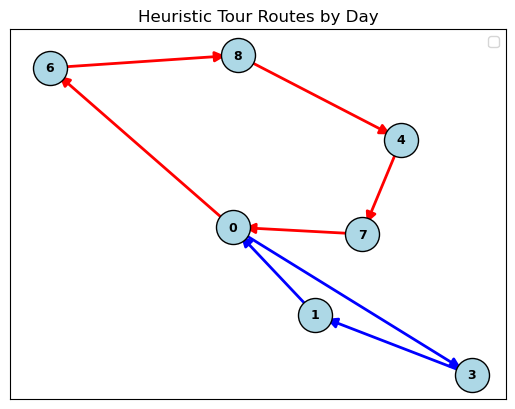

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_routes(routes):
    """
    Draw routes returned by heuristics like Nearest Neighbor.
    routes: dict of {day: [0, i1, i2, ..., 0]}
    """
    # Build arcs_by_day from route lists
    arcs_by_day = {}
    for d, r in routes.items():
        if len(r) > 1:
            arcs_by_day[d] = [(r[k], r[k+1]) for k in range(len(r)-1)]

    # Collect all nodes
    nodes = {i for arcs in arcs_by_day.values() for edge in arcs for i in edge}

    # Build a directed graph
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for arcs in arcs_by_day.values():
        G.add_edges_from(arcs)

    # Auto layout
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightblue", edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

    # Colors for days
    colors = ["red", "blue", "green", "orange", "purple", "brown"]

    # Draw arcs by day
    for idx, (d, arcs) in enumerate(sorted(arcs_by_day.items())):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=arcs,
            edge_color=colors[idx % len(colors)],
            arrows=True,
            arrowsize=15,
            width=2,
            label=f"Day {d}"
        )

    plt.legend()
    plt.title("Heuristic Tour Routes by Day")

plot_routes(routes)